In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import FreqDist
np.random.seed(1337)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [89]:
train_data = pd.read_csv('train.tsv', sep = '\t')
test_data = pd.read_csv('test.tsv', sep = '\t')

In [90]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [91]:
test_data.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [92]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [93]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
PhraseId      66292 non-null int64
SentenceId    66292 non-null int64
Phrase        66292 non-null object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [94]:
train_data.shape

(156060, 4)

In [95]:
test_data.shape

(66292, 3)

In [96]:
Sentiment_words = []
for row in train_data['Sentiment']:
    if row == 0:
        Sentiment_words.append('negative')
    elif row == 1:
        Sentiment_words.append('somewhat negative')
    elif row == 2:
        Sentiment_words.append('neutral')
    elif row == 3:
        Sentiment_words.append('somewhat positive')
    elif row == 4:
        Sentiment_words.append('positive')
    else:
        Sentiment_words.append('Failed')
        
train_data['Sentiment_words'] = Sentiment_words

In [97]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_words
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
1,2,1,A series of escapades demonstrating the adage ...,2,neutral
2,3,1,A series,2,neutral
3,4,1,A,2,neutral
4,5,1,series,2,neutral


In [98]:
sentiment_count = pd.value_counts(train_data['Sentiment_words'].values)
sentiment_count

neutral              79582
somewhat positive    32927
somewhat negative    27273
positive              9206
negative              7072
dtype: int64

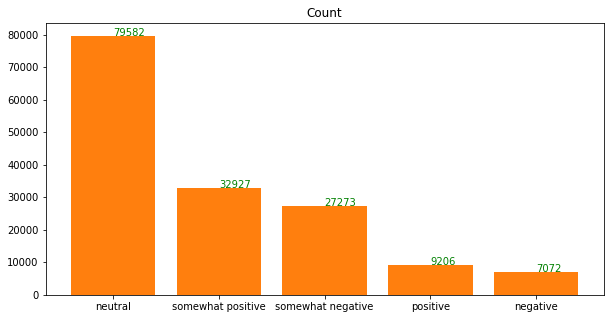

In [99]:
Idx = [1, 2, 3, 4, 5]
plt.figure(figsize = (10,5))
plt.bar(Idx, sentiment_count)
plt.xticks(Idx, ['neutral','somewhat positive','somewhat negative','positive','negative'])
plt.title('Count')
plt.bar(Idx, sentiment_count)
for a,b in zip(Idx, sentiment_count):
    plt.text(a, b, str(b), color = 'green')

In [100]:
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')
pstemmer = PorterStemmer()

In [101]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [102]:
def text_processing(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    text = re.sub("[^a-zA-Z]"," ", text)
    words = text.split()
    stops = list(stopwords.words("english"))
    stops.remove('no')
    stops.remove('not')
    stops.remove('very')
    words = [w for w in words if not w in set(stops)]
    #words = [stemmer.stem(word) for word in words]
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    if(len(words)==0):
        return ' '
    else:
        return (' '.join(words))

In [103]:
train_data.Phrase = train_data.Phrase.apply(lambda x: text_processing(x))
test_data.Phrase = test_data.Phrase.apply(lambda x: text_processing(x))

In [105]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_words
0,1,1,series escapade demonstrate adage good goose a...,1,somewhat negative
1,2,1,series escapade demonstrate adage good goose,2,neutral
2,3,1,series,2,neutral
4,5,1,series,2,neutral
5,6,1,escapade demonstrate adage good goose,2,neutral


In [106]:
train_data.shape

(154741, 5)

In [107]:
test_data.shape

(65595, 3)

In [31]:
train_data = pd.read_csv("train_processed.tsv", sep = '\t')
test_data = pd.read_csv("test_processed.tsv", sep = '\t')

In [109]:
words = ' '.join(train_data['Phrase'])
words = ' '.join([word for word in words.split()])

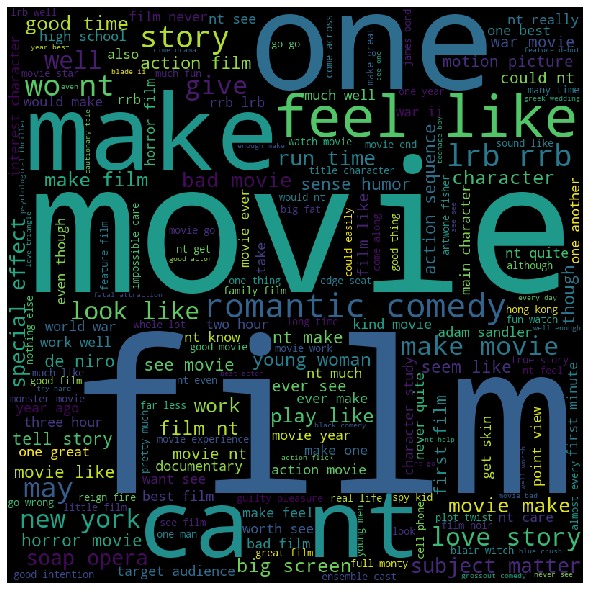

In [57]:
stops = set(stopwords.words("english"))

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stops, 
                min_font_size = 10).generate(words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [32]:
train_X = train_data['Phrase'].values
train_Y = to_categorical(train_data['Sentiment'].values)
test_X = test_data['Phrase'].values
print(train_X.shape, train_Y.shape, test_X.shape)

(154741,) (154741, 5) (65597,)


In [33]:
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.1, stratify = train_Y ,random_state=123)
print(train_X.shape,train_Y.shape)
print(val_X.shape,val_Y.shape)

(139266,) (139266, 5)
(15475,) (15475, 5)


In [34]:
all_words = ' '.join(train_X)
all_words = word_tokenize(all_words)
dist = FreqDist(all_words)
num_unique_word = len(dist)
num_unique_word

13490

In [35]:
r_len = []
for text in train_X:
    word = word_tokenize(text)
    l = len(word)
    r_len.append(l)
    
max_rlen = np.max(r_len)
max_rlen

30

In [36]:
max_features = num_unique_word
max_words = 100
batch_size = 128
epochs = 5
num_classes = 5

In [37]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(train_X))

In [38]:
def Tokenization(texts):
    data = tokenizer.texts_to_sequences(texts)
    data = pad_sequences(data, maxlen = max_words)
    return data

In [39]:
train_X = Tokenization(train_X)
val_X = Tokenization(val_X)
test_X = Tokenization(test_X)

In [40]:
print(len(train_X), len(val_X), len(test_X))

139266 15475 65597


In [41]:
print(train_X.shape,val_X.shape,test_X.shape)

(139266, 100) (15475, 100) (65597, 100)


In [42]:
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = train_X.shape[1], weights = [embedding_matrix], trainable=True))
model.add(Bidirectional(LSTM(32, dropout=0.4, recurrent_dropout=0.4)))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1349000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 1,434,125
Trainable params: 1,434,125
Non-trainable params: 0
_________________________________________________________________


In [43]:
weight_filepath = 'weights.hdf5'
checkpoint = ModelCheckpoint(
    weight_filepath,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callbacks_list = [checkpoint, early_stopping]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_X, train_Y, validation_data = (val_X, val_Y), epochs = epochs, batch_size = batch_size, verbose = 1, callbacks = callbacks_list)

model.load_weights(weight_filepath)

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 139266 samples, validate on 15475 samples
Epoch 1/5
139266/139266 [==============================] - 1385s 10ms/step - loss: 0.9856 - accuracy: 0.6095 - val_loss: 0.8508 - val_accuracy: 0.6535
Epoch 2/5
139266/139266 [==============================] - 1253s 9ms/step - loss: 0.7901 - accuracy: 0.6751 - val_loss: 0.8328 - val_accuracy: 0.6571
Epoch 3/5
139266/139266 [==============================] - 871s 6ms/step - loss: 0.7296 - accuracy: 0.6973 - val_loss: 0.8248 - val_accuracy: 0.6645
Epoch 4/5
139266/139266 [==============================] - 826s 6ms/step - loss: 0.6834 - accuracy: 0.7137 - val_loss: 0.8283 - val_accuracy: 0.6620
Epoch 5/5
139266/139266 [==============================] - 595s 4ms/step - loss: 0.6463 - accuracy: 0.7277 - val_loss: 0.8447 - val_accuracy: 0.6599


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


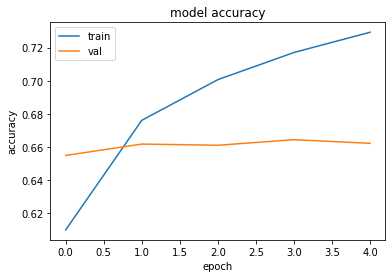

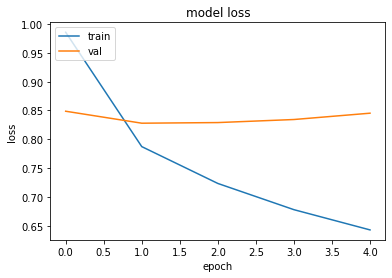

In [28]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [77]:
from tensorflow.keras.models import load_model
model = load_model('weights.hdf5')

y_pred=model.predict_classes(test_X)

sub_file = pd.read_csv('sampleSubmission.csv',sep=',')
sub_file.Sentiment=y_pred
sub_file.to_csv('Submission.csv',index=False)